# Cross-validation(k-fold)
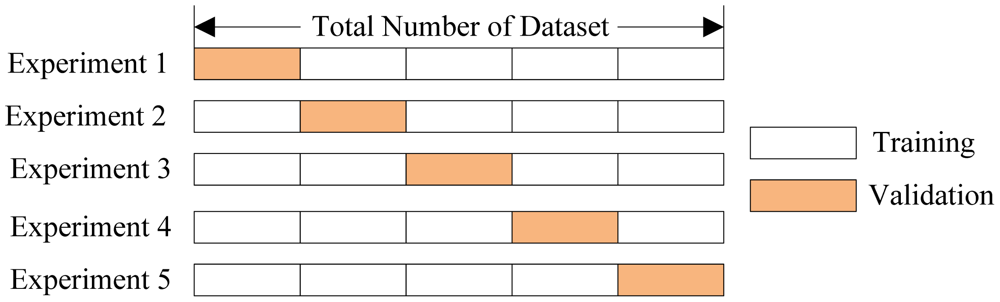
# This is guide about "How to build best machine learning model using cross validation"
****SUCH APPROACH ALSO USED IN STACKING
IDEA OF CROSS VALIDATION IS USED TO USED IN CHOOSE THE BEST MODEL,AND FIGHT WITH RETRAINING****

Author:Albert Bagdasarov.

****SELECTION OF THE OPTIMAL MODEL****

****So now we are gonna practise in educational process****
1. Estimate and validate model
2. Recruitment of most optimal hyperparameters
3. Mixing models
4. Took data signs from every model
5. Connect all models

We are gonna to solve binary classification task,to build algorithm which will identify if person's income are gonna exceed $50k. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=', ')
# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() # this method will divide dataset on columns like in massive above

df = df.replace('?', np.nan)

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x=='>50K')) # (True) > 50$,(False) < 50$

In [ ]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
categorial_data.head()

In [ ]:
df['education'].unique(), len(df['education'].unique())

# ONE HOTE ENCODING

*The main idea of this method consist in next statements.*

Let there one categorical variable(for example "color") take n different meanings(Red,Yellow,Green).So we could create n's new variables correspond to different categorical signs,which equal 1 and 0.

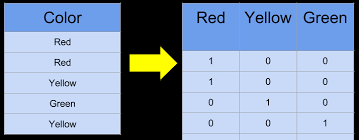

In [ ]:
dummy_features = pd.get_dummies(categorial_data)

In [ ]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X.head()

In [ ]:
y = df['salary']
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8)

In [ ]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, 
                            param_grid=parameters,
                            cv=5, 
                            scoring='f1',
                            n_jobs=-1, 
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error, 
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error, CV_model

In [ ]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]
param_scales = ['log', 'ordinary']

In [ ]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

Let's pick up parameters for n_estimators in random foresr algotihm.
Interesting Fact: Random Forest doesnt getting retraining.
Thats why graph will be monotonously rise.So we need to find the minimum meaning of n_estimators.
Every tree train separetly from others,so we just need to train forest.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [ ]:
max_trees = 100

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = []

for train_indices, val_indices in tqdm(kf.split(X_train), total=5):
    scores = []
    
    X_train_kf = X_train[train_indices]
    y_train_kf = y_train[train_indices]
    
    X_val_kf = X_train[val_indices]
    y_val_kf = y_train[val_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in tqdm(values, leave=False):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))
    
    scores = np.array(scores)
    
    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

In [ ]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values', color='red', lw=3)
plt.fill_between(values, 
                 mean_cross_val_score - 2 * std_cross_val_score, 
                 mean_cross_val_score + 2 * std_cross_val_score, 
                 color='green', 
                 label='filled area between errors',
                 alpha=0.5)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

****Feature normalization****

Normalize features and do the same with random forest.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

`StandardScaler` Perform transformation $$z = \frac{x - \mu}{\sigma}, \text{где $\sigma$ - Standart Deviation, а  $\mu$ - average}$$

In [ ]:
search_and_draw(X_train[:, numeric_indices], 
                y_train, 
                KNeighborsClassifier(), 
                'n_neighbors', 
                np.array(np.linspace(4, 30, 8), dtype='int'), 
                'ordinary')

In [ ]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

What also we can do?

We selected the optimal one-dimensional parameter for the algorithm. 

You can also:

1. Search the grid not only for numerical hyperparameters, but also for categorical ones, for example, a metric in the nearest neighbors algorithm or a branching criterion in a decision tree.
2. Search for the optimal parameter on a multidimensional grid. It will not work to go over all the possible options here, because it will take too much time. But you can iterate over random points on the grid. This procedure is called Randomized Grid Search.

# BOOSTING


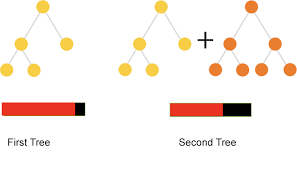

Let's try in a couple of lines to beat all the quality that we were looking for so hard.

In [ ]:
import xgboost # eXtreme gradient boosting model

In [ ]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Cool, yeah? There are other built-in implementations of gradient boosting besides XGBoost: these are LGBoost (light gradient boosting model) and built into the sklearn framework - GradientBoosting. In addition there is also CatBoost (categorical boosting, no cat was harmed), but more on that later.

In [ ]:
import lightgbm # light gradient boosting model

In [ ]:
boosting_model = lightgbm.LGBMClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
from  sklearn.ensemble import GradientBoostingClassifier

In [ ]:
boosting_model = GradientBoostingClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
import catboost # categorical boosting, cats have nothing to do with it.

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=500, silent=True, eval_metric='AUC')

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=500, silent=True, eval_metric='AUC')
boosting_model.grid_search({'l2_leaf_reg': np.linspace(0, 1, 20)}, X_train, y_train, plot=True, refit=True)

In [ ]:
y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

If you found this notebook useful,please upvote.